In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from pipelines import *

In [2]:
class PINN(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=200, output_dim=1, num_hidden_layers=2, activation_fn=torch.tanh):
        super(PINN, self).__init__()
        self.activation_fn = activation_fn  

        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t, a, b):
        a = a.repeat(x.size(0), 1)
        b = b.repeat(x.size(0), 1)

        # Объединяем x, t, a, b
        inputs = torch.cat([x, t, a, b], dim=1)

        x = self.activation_fn(self.input_layer(inputs))

        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))

        x = self.output_layer(x)
        return x

In [4]:
def compute_u_x(model, x_boundary, t_boundary, a, b):
    x_boundary.requires_grad_(True)
    u_boundary_pred = model(x_boundary, t_boundary, a, b)
    u_x = torch.autograd.grad(u_boundary_pred, x_boundary, grad_outputs=torch.ones_like(u_boundary_pred), create_graph=True)[0]
    return u_x

In [5]:
def boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b):
    u_x_0 = compute_u_x(model, x_boundary_0, t_boundary, a, b)
    u_x_pi = compute_u_x(model, x_boundary_pi, t_boundary, a, b)

    u_boundary_pred_0 = model(x_boundary_0, t_boundary, a, b)
    u_boundary_pred_pi = model(x_boundary_pi, t_boundary, a, b)
    u_boundary_0 = model(x_boundary, t_0, a, b)

    # Граничные условия
    boundary_0 = u_x_0 - u_boundary_pred_0 - (-torch.exp(-a * t_boundary) * (torch.cos(b * t_boundary) + torch.sin(b * t_boundary)))
    boundary_pi = u_x_pi - u_boundary_pred_pi - (torch.exp(-a * t_boundary) * (torch.cos(b * t_boundary) + torch.sin(b * t_boundary)))
    boundary_ = u_boundary_0 - torch.cos(x_boundary)

    # Потери на граничных условиях
    return torch.mean(boundary_0**2) + torch.mean(boundary_pi**2) + torch.mean(boundary_**2)


In [6]:
# Взвешенная функция потерь
def weighted_loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat"):
    # Потери на внутренних точках
    u_pred = model(x_interior, t_interior, a, b)
    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    if equation == "heat":
        physics_loss = u_t - a * u_xx
    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        physics_loss = u_tt - a * u_xx - b * u_t
    else:
        raise ValueError(f"Unknown equation type: {equation}")

    weight_interior = 1.0
    weight_boundary = 2.0
    b_loss = boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b)

    return weight_interior * torch.mean(physics_loss**2) + weight_boundary * b_loss


In [7]:
n_interior = 100
n_boundary = 200

x_interior = torch.tensor(np.linspace(0, np.pi, n_interior).reshape((n_interior, 1)), dtype=torch.float32, requires_grad=True)
t_interior = torch.tensor(np.random.uniform(0, 5, size=(n_interior, 1)), dtype=torch.float32, requires_grad=True)

x_boundary = torch.tensor(np.linspace(0, np.pi, n_boundary).reshape((n_boundary, 1)), dtype=torch.float32, requires_grad=True)
t_boundary = torch.tensor(np.random.uniform(0, 5, size=(n_boundary, 1)), dtype=torch.float32, requires_grad=True)

x_boundary_0 = torch.zeros_like(t_boundary, requires_grad=True)
x_boundary_pi = torch.full_like(t_boundary, np.pi, requires_grad=True)
t_0 = torch.zeros_like(x_boundary, requires_grad=True)

a_raw = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)
b_raw = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)

def sample_a_b():
    a_sample = np.random.uniform(a_min, a_max)
    b_sample = np.random.uniform(b_min, b_max)
    return torch.tensor(a_sample, dtype=torch.float32), torch.tensor(b_sample, dtype=torch.float32)


In [8]:
model = PINN(input_dim=4, hidden_dim=300, output_dim=1, num_hidden_layers=3, activation_fn=torch.sin)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
n_epochs = 10000
loss_history = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # Сэмплируем случайные значения a и b
    a, b = sample_a_b()

    # Вычисляем потери
    loss = weighted_loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat")
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Выводим текущие значения потерь
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item()}")

  0%|          | 3/10000 [00:00<07:48, 21.34it/s]

Epoch 0, Loss = 3.9071767330169678


 10%|█         | 1006/10000 [00:26<02:56, 51.01it/s]

Epoch 1000, Loss = 0.10764114558696747


 20%|██        | 2005/10000 [00:51<04:09, 32.05it/s]

Epoch 2000, Loss = 0.14810945093631744


 30%|███       | 3005/10000 [01:24<03:18, 35.31it/s]

Epoch 3000, Loss = 0.12581473588943481


 40%|████      | 4003/10000 [01:56<03:08, 31.73it/s]

Epoch 4000, Loss = 0.1778917908668518


 50%|█████     | 5005/10000 [02:37<03:16, 25.38it/s]

Epoch 5000, Loss = 0.05705665051937103


 60%|██████    | 6004/10000 [03:15<02:31, 26.37it/s]

Epoch 6000, Loss = 0.061238836497068405


 70%|███████   | 7007/10000 [03:51<01:34, 31.84it/s]

Epoch 7000, Loss = 0.0476788654923439


 80%|████████  | 8003/10000 [04:38<01:26, 23.22it/s]

Epoch 8000, Loss = 0.1429239809513092


 90%|█████████ | 9004/10000 [05:23<00:50, 19.79it/s]

Epoch 9000, Loss = 0.1624579280614853


100%|██████████| 10000/10000 [06:05<00:00, 27.35it/s]


In [12]:
def exact_solution(x, t, a, b):
    return np.exp(-a * t) * np.cos(x + b * t)

In [13]:
x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)

a_values = np.linspace(0.1, 2.0, 5)  # Например, 5 значений от 0.1 до 2.0
b_values = np.linspace(0.1, 2.0, 5)

In [14]:
metrics = evaluate_metrics(model, a_values, b_values, x_test, t_test, exact_solution)

a = 0.1, b = 0.1, Mean Error = 0.182852, Max Error = 0.503133
a = 0.1, b = 0.575, Mean Error = 0.331727, Max Error = 1.046810
a = 0.1, b = 1.05, Mean Error = 0.455556, Max Error = 1.496474
a = 0.1, b = 1.525, Mean Error = 0.484632, Max Error = 1.665779
a = 0.1, b = 2.0, Mean Error = 0.497548, Max Error = 1.735143
a = 0.575, b = 0.1, Mean Error = 0.132457, Max Error = 0.315122
a = 0.575, b = 0.575, Mean Error = 0.102807, Max Error = 0.512653
a = 0.575, b = 1.05, Mean Error = 0.171891, Max Error = 0.820442
a = 0.575, b = 1.525, Mean Error = 0.209276, Max Error = 1.071822
a = 0.575, b = 2.0, Mean Error = 0.233434, Max Error = 1.255450
a = 1.05, b = 0.1, Mean Error = 0.107514, Max Error = 0.456366
a = 1.05, b = 0.575, Mean Error = 0.072242, Max Error = 0.550749
a = 1.05, b = 1.05, Mean Error = 0.101590, Max Error = 0.705762
a = 1.05, b = 1.525, Mean Error = 0.139879, Max Error = 0.891339
a = 1.05, b = 2.0, Mean Error = 0.172650, Max Error = 1.070466
a = 1.525, b = 0.1, Mean Error = 0.08723

In [15]:
import pandas as pd
metrics_df = pd.DataFrame(metrics)

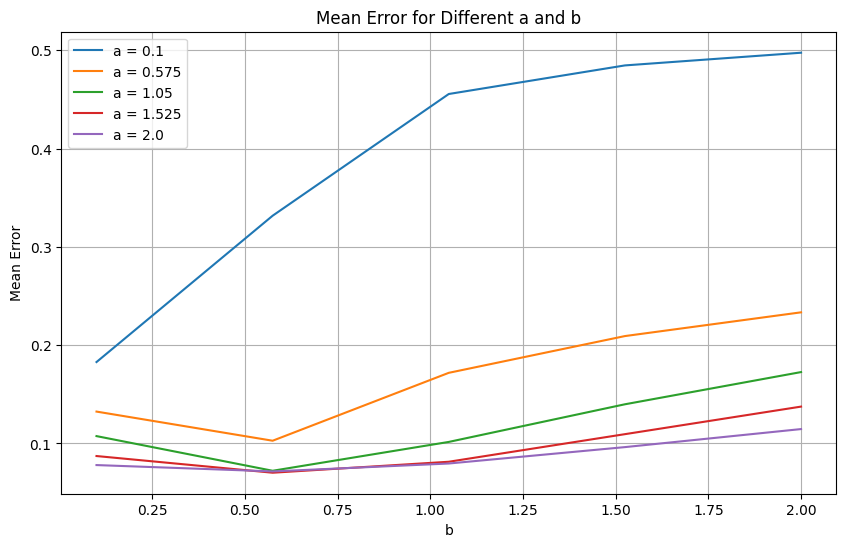

In [16]:
plt.figure(figsize=(10, 6))
for a_val in a_values:
    subset = metrics_df[metrics_df["a"] == a_val]
    plt.plot(subset["b"], subset["mean_error"], label=f"a = {a_val}")
plt.xlabel("b")
plt.ylabel("Mean Error")
plt.title("Mean Error for Different a and b")
plt.legend()
plt.grid()
plt.show()

Изменим loss функцию и добавим равномерное распределение параметров a и b 

In [39]:
def weighted_loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat"):
    # Потери на внутренних точках
    u_pred = model(x_interior, t_interior, a, b)
    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    if equation == "heat":
        physics_loss = u_t - a * u_xx
    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        physics_loss = u_tt - a * u_xx - b * u_t
    else:
        raise ValueError(f"Unknown equation type: {equation}")

    # Взвешиваем потери
    weight_interior = 1.0
    weight_boundary = 2.0
    b_loss = boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b)

    # Добавляем веса для сложных значений a и b
    complexity_weight = (1 + 2 * (a - 1)**2 + 2 * (b - 1)**2)  # Увеличиваем вес для параметров далеко от 1

    return complexity_weight * (weight_interior * torch.mean(physics_loss**2) + weight_boundary * b_loss)


In [19]:
def generate_uniform_samples(a_min, a_max, b_min, b_max, num_samples):
    a_samples = np.linspace(a_min, a_max, num_samples)
    b_samples = np.linspace(b_min, b_max, num_samples)
    return np.array(np.meshgrid(a_samples, b_samples)).T.reshape(-1, 2)

In [33]:
# Ограничение диапазона параметров a и b
a_min, a_max = 0, 5
b_min, b_max = 0, 5

def get_constrained_params(a_raw, b_raw):
    a = torch.sigmoid(a_raw) * (a_max - a_min) + a_min
    b = torch.sigmoid(b_raw) * (b_max - b_min) + b_min
    return a, b


In [ ]:
model = PINN(input_dim=4, hidden_dim=500, output_dim=1, num_hidden_layers=5, activation_fn=torch.relu)

# Инициализация оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

stages = [
    {"a_min": 0.1, "a_max": 1.0, "b_min": 0.1, "b_max": 1.0, "epochs": 3000},
    {"a_min": 1.0, "a_max": 2.5, "b_min": 1.0, "b_max": 2.5, "epochs": 3000},
    {"a_min": 2.5, "a_max": 5.0, "b_min": 2.5, "b_max": 5.0, "epochs": 4000}
]

loss_history = []
smoothed_loss = 0.0  # Для сглаживания

for stage in stages:
    a_min_stage, a_max_stage = stage["a_min"], stage["a_max"]
    b_min_stage, b_max_stage = stage["b_min"], stage["b_max"]
    stage_epochs = stage["epochs"]

    for epoch in tqdm(range(stage_epochs)):
        optimizer.zero_grad()

        # Выбираем случайный набор a и b из диапазона текущего этапа
        a = np.random.uniform(a_min_stage, a_max_stage)
        b = np.random.uniform(b_min_stage, b_max_stage)
        a = torch.tensor(a, dtype=torch.float32)
        b = torch.tensor(b, dtype=torch.float32)

        # Вычисляем потери
        loss = weighted_loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat")
        loss.backward()
        optimizer.step()

        # Обновляем сглаженное значение функции потерь
        smoothed_loss = 0.9 * smoothed_loss + 0.1 * loss.item() if epoch > 0 else loss.item()

        # Сохраняем потери
        loss_history.append(smoothed_loss)

        # Выводим текущие значения потерь каждые 1000 эпох
        if epoch % 1000 == 0:
            print(f"Stage {stages.index(stage) + 1}, Epoch {epoch}, Smoothed Loss = {smoothed_loss:.6f}, Current Loss = {loss.item():.6f}")


  0%|          | 4/3000 [00:00<02:56, 16.96it/s]

Stage 1, Epoch 0, Smoothed Loss = 1.855916, Current Loss = 1.855916


 33%|███▎      | 1004/3000 [00:43<01:23, 23.95it/s]

Stage 1, Epoch 1000, Smoothed Loss = 0.220472, Current Loss = 0.074047


 67%|██████▋   | 2005/3000 [01:26<00:40, 24.68it/s]

Stage 1, Epoch 2000, Smoothed Loss = 0.295556, Current Loss = 0.117976


  0%|          | 3/3000 [00:00<02:04, 24.15it/s]

Stage 2, Epoch 0, Smoothed Loss = 2.085428, Current Loss = 2.085428


 34%|███▎      | 1005/3000 [00:41<01:24, 23.55it/s]

Stage 2, Epoch 1000, Smoothed Loss = 0.581896, Current Loss = 1.137545


 67%|██████▋   | 2004/3000 [01:35<00:55, 17.94it/s]

Stage 2, Epoch 2000, Smoothed Loss = 0.394411, Current Loss = 0.051765


  0%|          | 4/4000 [00:00<03:36, 18.45it/s]

Stage 3, Epoch 0, Smoothed Loss = 10.886066, Current Loss = 10.886066


 25%|██▌       | 1005/4000 [00:57<02:28, 20.14it/s]

Stage 3, Epoch 1000, Smoothed Loss = 5.266472, Current Loss = 5.805941


 50%|█████     | 2003/4000 [01:51<01:42, 19.50it/s]

Stage 3, Epoch 2000, Smoothed Loss = 4.625945, Current Loss = 2.834561


 75%|███████▌  | 3003/4000 [02:42<00:50, 19.73it/s]

Stage 3, Epoch 3000, Smoothed Loss = 5.611697, Current Loss = 3.240437


100%|██████████| 4000/4000 [03:34<00:00, 18.62it/s]


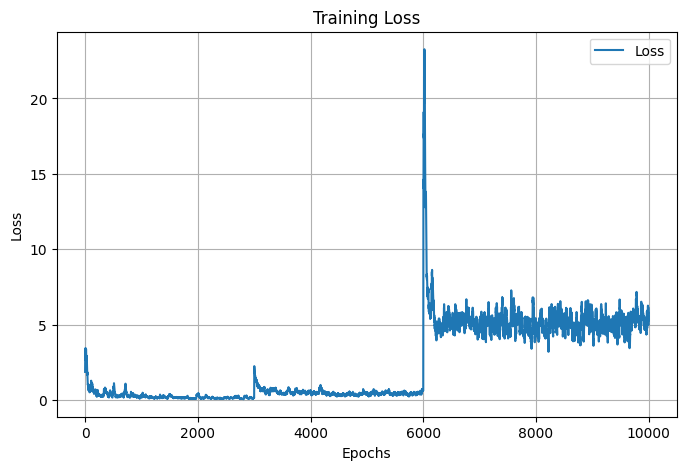

In [47]:
plot_loss(loss_history)

In [48]:
x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)

a_values = np.linspace(0.1, 2.0, 5) 
b_values = np.linspace(0.1, 2.0, 5)

metrics = evaluate_metrics(model, a_values, b_values, x_test, t_test, exact_solution)
metrics_df = pd.DataFrame(metrics)

a = 0.1, b = 0.1, Mean Error = 0.878335, Max Error = 3.678381
a = 0.1, b = 0.575, Mean Error = 0.938055, Max Error = 4.531746
a = 0.1, b = 1.05, Mean Error = 1.140588, Max Error = 3.920818
a = 0.1, b = 1.525, Mean Error = 0.996329, Max Error = 3.561750
a = 0.1, b = 2.0, Mean Error = 1.011646, Max Error = 3.700935
a = 0.575, b = 0.1, Mean Error = 0.944082, Max Error = 3.848785
a = 0.575, b = 0.575, Mean Error = 0.896658, Max Error = 3.669448
a = 0.575, b = 1.05, Mean Error = 0.912962, Max Error = 3.323401
a = 0.575, b = 1.525, Mean Error = 0.878024, Max Error = 3.060608
a = 0.575, b = 2.0, Mean Error = 0.856611, Max Error = 2.897632
a = 1.05, b = 0.1, Mean Error = 0.942703, Max Error = 3.561091
a = 1.05, b = 0.575, Mean Error = 0.873892, Max Error = 3.308205
a = 1.05, b = 1.05, Mean Error = 0.846137, Max Error = 3.043014
a = 1.05, b = 1.525, Mean Error = 0.814293, Max Error = 2.782634
a = 1.05, b = 2.0, Mean Error = 0.783409, Max Error = 2.594018
a = 1.525, b = 0.1, Mean Error = 0.91621

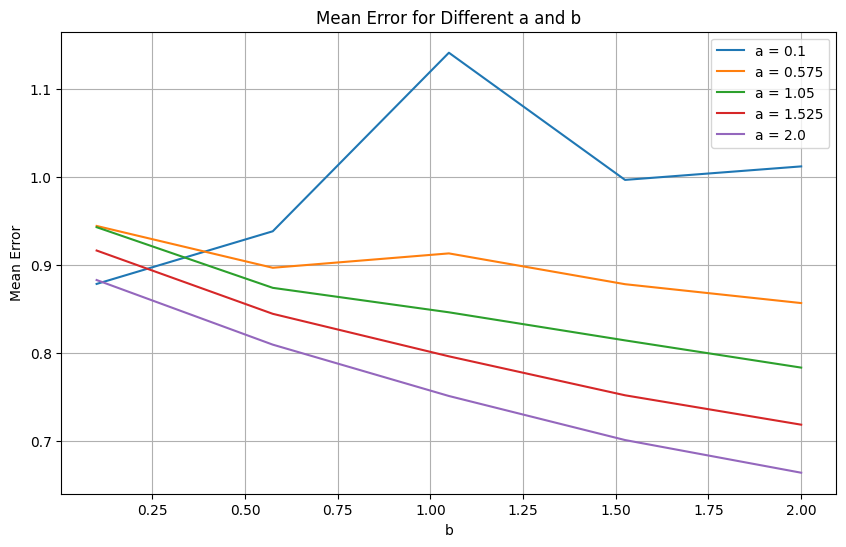

In [49]:
plt.figure(figsize=(10, 6))
for a_val in a_values:
    subset = metrics_df[metrics_df["a"] == a_val]
    plt.plot(subset["b"], subset["mean_error"], label=f"a = {a_val}")
plt.xlabel("b")
plt.ylabel("Mean Error")
plt.title("Mean Error for Different a and b")
plt.legend()
plt.grid()
plt.show()

In [56]:
model = PINN(input_dim=4, hidden_dim=300, output_dim=1, num_hidden_layers=5, activation_fn=torch.sin)

stages = [
    {"a_min": 0., "a_max": 1.0, "b_min": 0.1, "b_max": 1.0, "epochs": 3000, "lr": 0.001},
    {"a_min": 1.0, "a_max": 2.5, "b_min": 1.0, "b_max": 2.5, "epochs": 3000, "lr": 0.0005},
    {"a_min": 2.5, "a_max": 5.0, "b_min": 2.5, "b_max": 5.0, "epochs": 4000, "lr": 0.0001}
]

loss_history = []
smoothed_loss = 0.0  

for stage in stages:
    a_min_stage, a_max_stage = stage["a_min"], stage["a_max"]
    b_min_stage, b_max_stage = stage["b_min"], stage["b_max"]
    stage_epochs = stage["epochs"]

    optimizer = torch.optim.Adam(model.parameters(), lr=stage["lr"], weight_decay=1e-4)

    for epoch in tqdm(range(stage_epochs)):
        optimizer.zero_grad()

        a = np.random.uniform(a_min_stage, a_max_stage)
        b = np.random.uniform(b_min_stage, b_max_stage)
        a = torch.tensor(a, dtype=torch.float32)
        b = torch.tensor(b, dtype=torch.float32)

        loss = weighted_loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat")
        loss.backward()
        optimizer.step()

        smoothed_loss = 0.9 * smoothed_loss + 0.1 * loss.item() if epoch > 0 else loss.item()

        loss_history.append(smoothed_loss)

        if epoch % 1000 == 0:
            print(f"Stage {stages.index(stage) + 1}, Epoch {epoch}, Smoothed Loss = {smoothed_loss:.6f}, Current Loss = {loss.item():.6f}")


  0%|          | 7/3000 [00:00<01:42, 29.07it/s]

Stage 1, Epoch 0, Smoothed Loss = 4.046742, Current Loss = 4.046742


 34%|███▎      | 1006/3000 [00:27<00:52, 38.26it/s]

Stage 1, Epoch 1000, Smoothed Loss = 0.772495, Current Loss = 2.274623


 67%|██████▋   | 2009/3000 [00:55<00:24, 40.94it/s]

Stage 1, Epoch 2000, Smoothed Loss = 0.559075, Current Loss = 1.113574


  0%|          | 5/3000 [00:00<01:16, 39.24it/s]

Stage 2, Epoch 0, Smoothed Loss = 2.306921, Current Loss = 2.306921


 34%|███▎      | 1007/3000 [00:26<00:49, 40.12it/s]

Stage 2, Epoch 1000, Smoothed Loss = 0.319711, Current Loss = 0.142895


 67%|██████▋   | 2005/3000 [00:53<00:27, 36.18it/s]

Stage 2, Epoch 2000, Smoothed Loss = 0.003225, Current Loss = 0.001949


  0%|          | 4/4000 [00:00<02:12, 30.20it/s]

Stage 3, Epoch 0, Smoothed Loss = 93.920692, Current Loss = 93.920692


 25%|██▌       | 1004/4000 [00:38<03:24, 14.64it/s]

Stage 3, Epoch 1000, Smoothed Loss = 0.767868, Current Loss = 0.707478


 50%|█████     | 2004/4000 [01:47<01:45, 18.89it/s]

Stage 3, Epoch 2000, Smoothed Loss = 0.056632, Current Loss = 0.035223


 75%|███████▌  | 3004/4000 [02:45<00:53, 18.55it/s]

Stage 3, Epoch 3000, Smoothed Loss = 0.056035, Current Loss = 0.027734


100%|██████████| 4000/4000 [03:36<00:00, 18.44it/s]


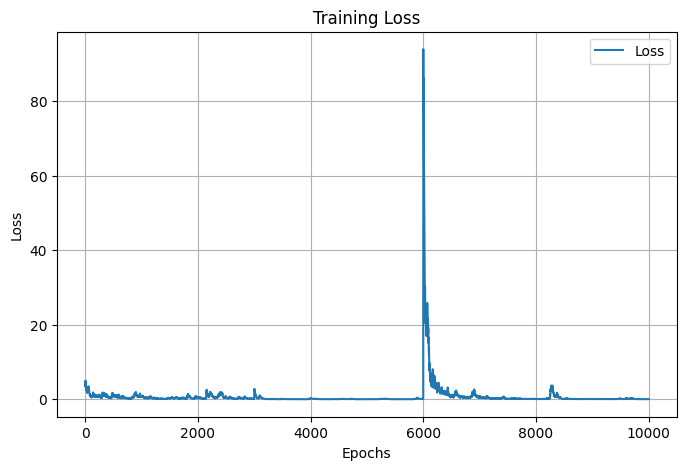

In [57]:
plot_loss(loss_history)

In [58]:
x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)

a_values = np.linspace(0.1, 5.0, 20) 
b_values = np.linspace(0.1, 5.0, 20)

metrics = evaluate_metrics(model, a_values, b_values, x_test, t_test, exact_solution)
metrics_df = pd.DataFrame(metrics)

a = 0.1, b = 0.1, Mean Error = 0.268189, Max Error = 0.685489
a = 0.1, b = 0.35789473684210527, Mean Error = 0.234182, Max Error = 0.568422
a = 0.1, b = 0.6157894736842106, Mean Error = 0.366636, Max Error = 0.753579
a = 0.1, b = 0.8736842105263158, Mean Error = 0.426016, Max Error = 0.949017
a = 0.1, b = 1.1315789473684212, Mean Error = 0.453291, Max Error = 1.076544
a = 0.1, b = 1.3894736842105266, Mean Error = 0.488508, Max Error = 1.150374
a = 0.1, b = 1.6473684210526318, Mean Error = 0.527832, Max Error = 1.201162
a = 0.1, b = 1.905263157894737, Mean Error = 0.534534, Max Error = 1.244659
a = 0.1, b = 2.1631578947368424, Mean Error = 0.516023, Max Error = 1.288623
a = 0.1, b = 2.421052631578948, Mean Error = 0.520878, Max Error = 1.343736
a = 0.1, b = 2.678947368421053, Mean Error = 0.527425, Max Error = 1.419867
a = 0.1, b = 2.936842105263158, Mean Error = 0.521926, Max Error = 1.470476
a = 0.1, b = 3.1947368421052635, Mean Error = 0.515649, Max Error = 1.463228
a = 0.1, b = 3.45

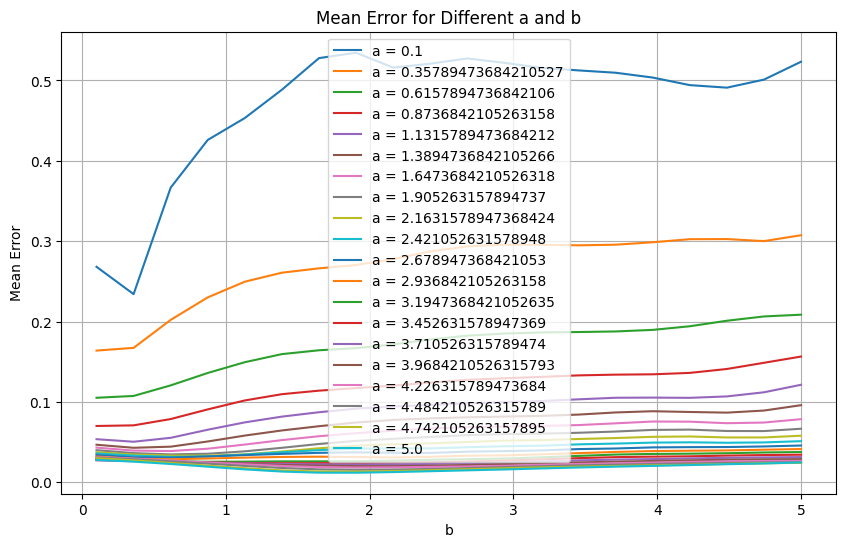

In [59]:
plt.figure(figsize=(10, 6))
for a_val in a_values:
    subset = metrics_df[metrics_df["a"] == a_val]
    plt.plot(subset["b"], subset["mean_error"], label=f"a = {a_val}")
plt.xlabel("b")
plt.ylabel("Mean Error")
plt.title("Mean Error for Different a and b")
plt.legend()
plt.grid()
plt.show()

In [60]:
# Тестирование точного решения
def exact_solution(x, t, a, b):
    return np.exp(-a * t) * np.cos(x + b * t)

x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

a_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)
b_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)


u_pred = model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1), a_test, b_test).detach().numpy().reshape(x_mesh.shape)
u_exact = exact_solution(x_mesh.numpy(), t_mesh.numpy(), a_test.item(), b_test.item())

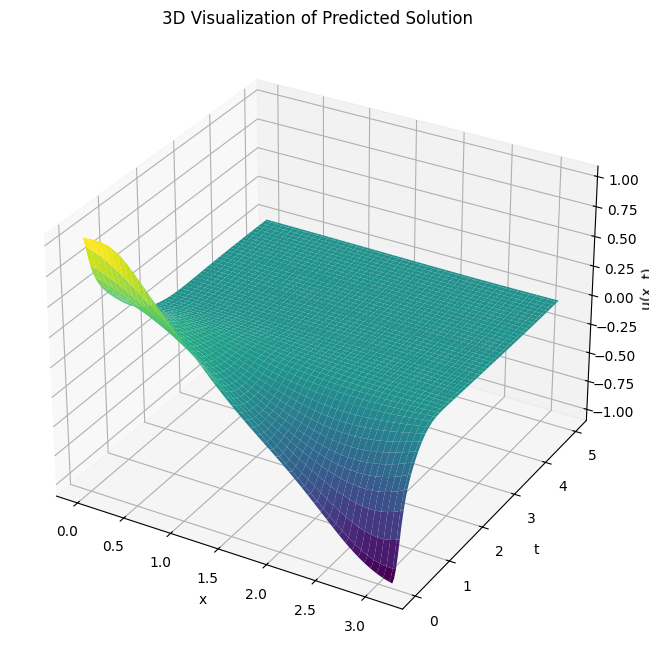

In [61]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_pred, cmap="viridis")
ax.set_title("3D Visualization of Predicted Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()

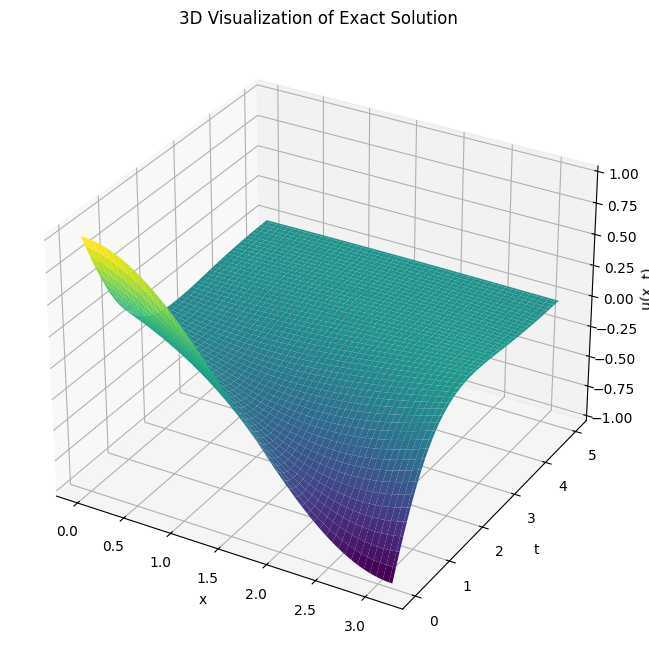

In [62]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_exact, cmap="viridis")
ax.set_title("3D Visualization of Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()